In [105]:
import torch
from typing import Any, Dict, Optional

import torch
from torch.nn import (
    BatchNorm1d,
    Embedding,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.datasets import Planetoid, TUDataset, LRGBDataset
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GINConv, GATv2Conv, GPSConv, global_add_pool,global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn.attention import PerformerAttention
from torch_geometric import utils
import networkx as nx
from scipy.sparse.linalg import eigsh
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import get_laplacian, to_scipy_sparse_matrix, to_undirected, to_dense_adj, scatter
from torch_geometric.utils.num_nodes import maybe_num_nodes
from scipy.sparse.linalg import eigsh
import torch.nn as nn
import numpy as np

### Helper Functions

In [223]:
def compute_clustering_coefficient(edge_index, max_num_nodes):
    adj = to_dense_adj(edge_index, max_num_nodes=max_num_nodes).squeeze(0)
    deg = adj.sum(dim=1)
    triangle = torch.mm(adj, torch.mm(adj, adj))
    clustering = triangle.diag() / (deg * (deg - 1))
    clustering[deg <= 1] = 0.0
    return clustering
def compute_laplacian(graph, k, N, dev):
    edge_i, edge_w = get_laplacian(graph.edge_index, normalization="sym", num_nodes=N)
    dense_L = to_dense_adj(edge_index=edge_i, edge_attr=edge_w).squeeze()
    L = np.asarray(dense_L.cpu())
    eigval, eigvec = np.linalg.eigh(L)
    lapse = torch.tensor(eigvec[:, :k], device=dev)
    length = lapse.size(1)
    if length < k: ## zero padding if k > length
        lapse = torch.concat([lapse, torch.zeros((N, k - length), device=dev)], dim=-1)
    return lapse
def feature_augmentation(datasetlst, features, dev, k=4):
    ## features=True if it already has features.
    for graph in datasetlst:
        if graph.x is not None:
            graph.x = graph.x.to(dev)
        graph.edge_index = graph.edge_index.to(dev)
        num_nodes = graph.x.shape[0] if features else graph.num_nodes
        concat_edges = torch.cat([graph.edge_index[0], graph.edge_index[1]], dim=-1)
        degrees = utils.degree(concat_edges, num_nodes=num_nodes).view(-1, 1)
        constant = torch.ones((num_nodes, 1), device=dev) 
        clustering = compute_clustering_coefficient(graph.edge_index, num_nodes).view(-1, 1) 
        lapse = compute_laplacian(graph, k=k, N=num_nodes, dev=dev)
        if features:
            graph.pe = torch.cat([constant, degrees, clustering, lapse], dim=-1).to(dev)
            graph.x = graph.x.to(dev)
        else:
            graph.pe = torch.cat([constant, degrees, clustering,], dim=-1).to(dev)
            # add features to the graph
            graph.x = torch.cat([constant, degrees, clustering,], dim=-1).to(dev)

## Loading Datasets, Adding Features and Defining Loaders

In [355]:
# using cpu because of torch device issues
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

cora_ds = Planetoid(root='/tmp/Planetoid', name='Cora')
imdb_ds = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
enzyme_ds = TUDataset(root='/tmp/ENZYME', name='ENZYMES')
lrgb_ds = LRGBDataset(root='/tmp/LRGB', name='Peptides-func')

cora = list(cora_ds)
imdb = list(imdb_ds)
enzyme = list(enzyme_ds)
lrgb = list(lrgb_ds)

Device: cpu


Extracting \tmp\LRGB\peptidesfunc.zip
Processing...
Processing test dataset: 100%|██████████| 2331/2331 [00:00<00:00, 55503.71it/s]
Done!


In [357]:
feature_augmentation(cora, features=True, dev=device)
feature_augmentation(imdb, features=False, dev=device)
feature_augmentation(enzyme, features=True, dev=device)
feature_augmentation(lrgb, features=True, dev=device)

In [358]:
imdb_idxs = np.random.choice(len(imdb), int(len(imdb) * 0.8), replace=False)
imdb_train = [imdb[i] for i in imdb_idxs]
imdb_test = [imdb[i] for i in range(len(imdb)) if i not in imdb_idxs]

enzyme_idxs = np.random.choice(len(enzyme), int(len(enzyme) * 0.8), replace=False)
enzyme_train = [enzyme[i] for i in enzyme_idxs]
enzyme_test = [enzyme[i] for i in range(len(enzyme)) if i not in enzyme_idxs]

lrgb_idxs = np.random.choice(len(lrgb), int(len(lrgb) * 0.8), replace=False)
lrgb_train = [lrgb[i] for i in lrgb_idxs]
lrgb_test = [lrgb[i] for i in range(len(lrgb)) if i not in lrgb_idxs]

In [359]:
cora_loader = DataLoader(cora, batch_size=64, shuffle=True)

imdb_trainloader = DataLoader(imdb_train, batch_size=64, shuffle=True)
imdb_testloader = DataLoader(imdb_test, batch_size=64, shuffle=False)

enzyme_trainloader = DataLoader(enzyme_train, batch_size=64, shuffle=True)
enzyme_testloader = DataLoader(enzyme_test, batch_size=64, shuffle=False)

lrgb_trainloader = DataLoader(lrgb_train, batch_size=64, shuffle=True)
lrgb_testloader = DataLoader(lrgb_test, batch_size=64, shuffle=False)

## Defining the Models

### Define Models for Node Classification

In [349]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim)))
        self.conv2 = GINConv(torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, output_dim)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class GATv2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(input_dim, hidden_dim, heads=4)
        self.conv2 = GATv2Conv(hidden_dim * 4, output_dim, heads=4, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class GPS(torch.nn.Module):
    def __init__(self, num_node_feats: int, channels: int, pe_size: int, pe_dim: int, num_layers: int, output_dim: int):
        super().__init__()
        
        self.pe_norm = BatchNorm1d(pe_size).to(device)
        self.preprocessing = nn.Linear(num_node_feats + pe_size, channels)
        self.dropout = nn.Dropout(0.5)
        self.convs = ModuleList()
        for _ in range(num_layers):
            mlp_ = Sequential(
                Linear(channels, channels),
                ReLU(),
                Linear(channels, channels),
            )
            conv = GPSConv(channels, GINConv(mlp_), heads=4)
            self.convs.append(conv)

        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, output_dim),
        )
        
    def forward(self, x, pe, edge_index, batch):
        x_pe = self.pe_norm(pe)
        x = torch.cat((x, x_pe), 1)
        x = self.dropout(x)
        x = self.preprocessing(x)
        for conv in self.convs:
            x = conv(x, edge_index, batch)
        # x = global_add_pool(x, batch)
        x = self.mlp(x)
        return x


### Define Models for Graph Classification

In [ ]:
class GCNG(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNG, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim, dropout=0.6)
        self.conv15 = GCNConv(hidden_dim, hidden_dim, dropout=0.6)
        self.conv2 = GCNConv(hidden_dim, output_dim, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv15(x, edge_index))
        x = self.conv2(x, edge_index)
        x = gmp(x, data.batch)
        return x

class GING(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GING, self).__init__()
        self.conv1 = GINConv(torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.Sigmoid(), torch.nn.Linear(hidden_dim, hidden_dim))
        , dropout=0.6)
        self.conv2 = GINConv(torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.Sigmoid(), torch.nn.Linear(hidden_dim, output_dim))
        , dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = gmp(x, data.batch)
        return x
    
class GATv2G(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATv2G, self).__init__()
        self.conv1 = GATv2Conv(input_dim, hidden_dim, heads=4, dropout=0.6)
        self.conv2 = GATv2Conv(hidden_dim * 4, output_dim, heads=4, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = gmp(x, data.batch)
        return x
    
class GPSG(torch.nn.Module):
    def __init__(self, num_node_feats: int, channels: int, pe_size: int, pe_dim: int, num_layers: int, output_dim: int):
        super().__init__()
        
        self.pe_norm = BatchNorm1d(pe_size).to(device)
        self.preprocessing = nn.Linear(num_node_feats + pe_size, channels)
        self.dropout = nn.Dropout(0.5)
        self.convs = ModuleList()
        for _ in range(num_layers):
            mlp_ = Sequential(
                Linear(channels, channels),
                ReLU(),
                Linear(channels, channels),
            )
            conv = GPSConv(channels, GINConv(mlp_), heads=4)
            self.convs.append(conv)

        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, output_dim),
        )
        
    def forward(self, x, pe, edge_index, batch):
        x_pe = self.pe_norm(pe)
        x = torch.cat((x, x_pe), 1)
        x = self.dropout(x)
        x = self.preprocessing(x)
        for conv in self.convs:
            x = conv(x, edge_index, batch)
        x = self.mlp(x)
        x = gmp(x, batch)
        return x


## Training on Cora

In [86]:
GCN_model = GCN(cora_ds[0].num_node_features, 16, cora_ds.num_classes)
GIN_model = GIN(cora_ds[0].num_node_features, 16, cora_ds.num_classes)
GATv2_model = GATv2(cora_ds[0].num_node_features, 16, cora_ds.num_classes)
GPS_model = GPS(cora_ds[0].num_node_features, 32, 7, 8, 3, cora_ds.num_classes)
models = [GCN_model, GIN_model, GATv2_model, GPS_model]

hist = {}
hist['GCN'] = []
hist['GIN'] = []
hist['GATv2'] = []
hist['GPS'] = []

In [87]:
def train_GPS(epoch, model, optimizer, train_loader):
    model.train()
    loss_all = 0
    
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data.x, data.pe, data.edge_index, data.batch)
        # print(output.shape)
        # print(output)
        output = output[data.train_mask]
        y = data.y[data.train_mask]
        loss = F.cross_entropy(output, y)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()

    return loss_all

def test_GPS(model, loader):
    model.eval()
    correct = 0
    tot = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data.x, data.pe, data.edge_index, data.batch).max(dim=1)[1]
            pred = pred[data.test_mask]
            y = data.y[data.test_mask]
            correct += pred.eq(y).sum().item()
            tot = y.size(0)
    return correct / tot 

optimizer = torch.optim.Adam(GPS_model.parameters(), lr=0.01)

for epoch in range(1, 101):
    loss = train_GPS(epoch, GPS_model, optimizer, cora_loader)
    test_acc = test_GPS(GPS_model, cora_loader)
    # scheduler.step(loss)
    hist['GPS'].append((epoch, loss, test_acc))
    print('Epoch: {:03d}, Loss: {:.5f}, Test: {:.5f}'.format(epoch, loss, test_acc))

Epoch: 001, Loss: 2.01394, Test: 0.12800
Epoch: 002, Loss: 1.88710, Test: 0.08200
Epoch: 003, Loss: 1.79216, Test: 0.07200
Epoch: 004, Loss: 1.68177, Test: 0.06600
Epoch: 005, Loss: 1.52048, Test: 0.15500
Epoch: 006, Loss: 1.43182, Test: 0.16300
Epoch: 007, Loss: 1.35484, Test: 0.13800
Epoch: 008, Loss: 1.29896, Test: 0.15900
Epoch: 009, Loss: 1.27067, Test: 0.19300
Epoch: 010, Loss: 1.25223, Test: 0.21000
Epoch: 011, Loss: 1.08192, Test: 0.31000
Epoch: 012, Loss: 1.01568, Test: 0.40200
Epoch: 013, Loss: 0.99822, Test: 0.44700
Epoch: 014, Loss: 0.90216, Test: 0.45100
Epoch: 015, Loss: 0.85971, Test: 0.44500
Epoch: 016, Loss: 0.76855, Test: 0.45700
Epoch: 017, Loss: 0.77145, Test: 0.43400
Epoch: 018, Loss: 0.71937, Test: 0.44700
Epoch: 019, Loss: 0.63654, Test: 0.42100
Epoch: 020, Loss: 0.59938, Test: 0.37800
Epoch: 021, Loss: 0.54906, Test: 0.31700
Epoch: 022, Loss: 0.49379, Test: 0.30800
Epoch: 023, Loss: 0.49205, Test: 0.30300
Epoch: 024, Loss: 0.39934, Test: 0.32400
Epoch: 025, Loss

In [88]:
def train_on_cora(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in cora_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}')
        eval_acc = evaluate_on_cora(model)
        hist[model.__class__.__name__].append((epoch + 1, total_loss, eval_acc))
    return total_loss

def evaluate_on_cora(model):
    model.eval()
    correct = 0
    tot = 0
    for data in cora_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        tot = data.y.size(0)
    return correct / tot if tot != 0 else 0

for model in models[:-1]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss = train_on_cora(model, optimizer, 100)
    acc = evaluate_on_cora(model)
    print(model.__class__.__name__, 'Cora', acc)

Epoch: 000, Loss: 1.9577
Epoch: 001, Loss: 1.9001
Epoch: 002, Loss: 1.8463
Epoch: 003, Loss: 1.7843
Epoch: 004, Loss: 1.7165
Epoch: 005, Loss: 1.6464
Epoch: 006, Loss: 1.5749
Epoch: 007, Loss: 1.5019
Epoch: 008, Loss: 1.4283
Epoch: 009, Loss: 1.3550
Epoch: 010, Loss: 1.2822
Epoch: 011, Loss: 1.2102
Epoch: 012, Loss: 1.1400
Epoch: 013, Loss: 1.0721
Epoch: 014, Loss: 1.0066
Epoch: 015, Loss: 0.9435
Epoch: 016, Loss: 0.8828
Epoch: 017, Loss: 0.8247
Epoch: 018, Loss: 0.7692
Epoch: 019, Loss: 0.7162
Epoch: 020, Loss: 0.6659
Epoch: 021, Loss: 0.6181
Epoch: 022, Loss: 0.5728
Epoch: 023, Loss: 0.5301
Epoch: 024, Loss: 0.4897
Epoch: 025, Loss: 0.4517
Epoch: 026, Loss: 0.4161
Epoch: 027, Loss: 0.3828
Epoch: 028, Loss: 0.3518
Epoch: 029, Loss: 0.3230
Epoch: 030, Loss: 0.2964
Epoch: 031, Loss: 0.2719
Epoch: 032, Loss: 0.2494
Epoch: 033, Loss: 0.2287
Epoch: 034, Loss: 0.2098
Epoch: 035, Loss: 0.1925
Epoch: 036, Loss: 0.1767
Epoch: 037, Loss: 0.1623
Epoch: 038, Loss: 0.1492
Epoch: 039, Loss: 0.1373


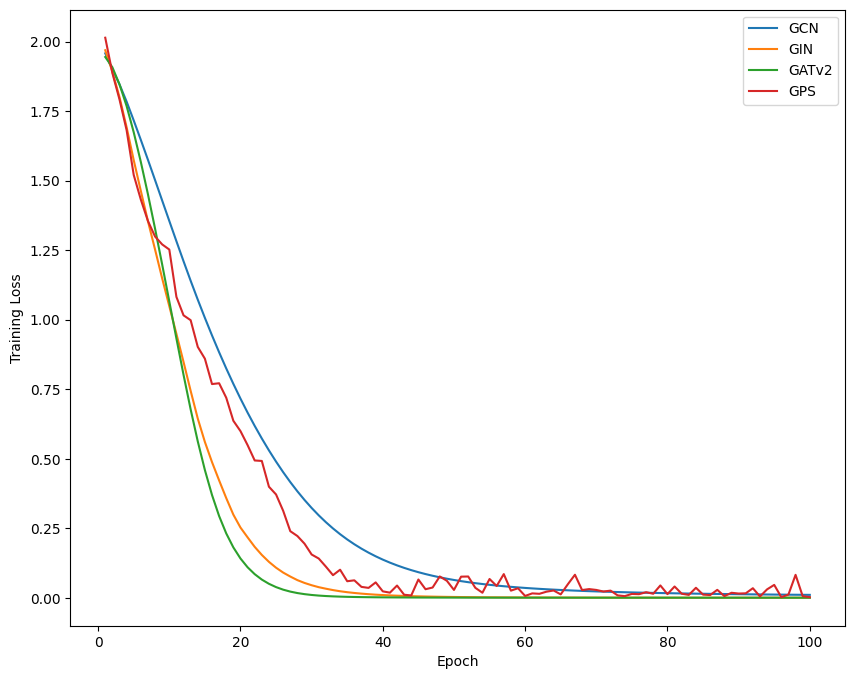

In [89]:
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__]], [x[1] for x in hist[model.__class__.__name__]], label=model.__class__.__name__)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

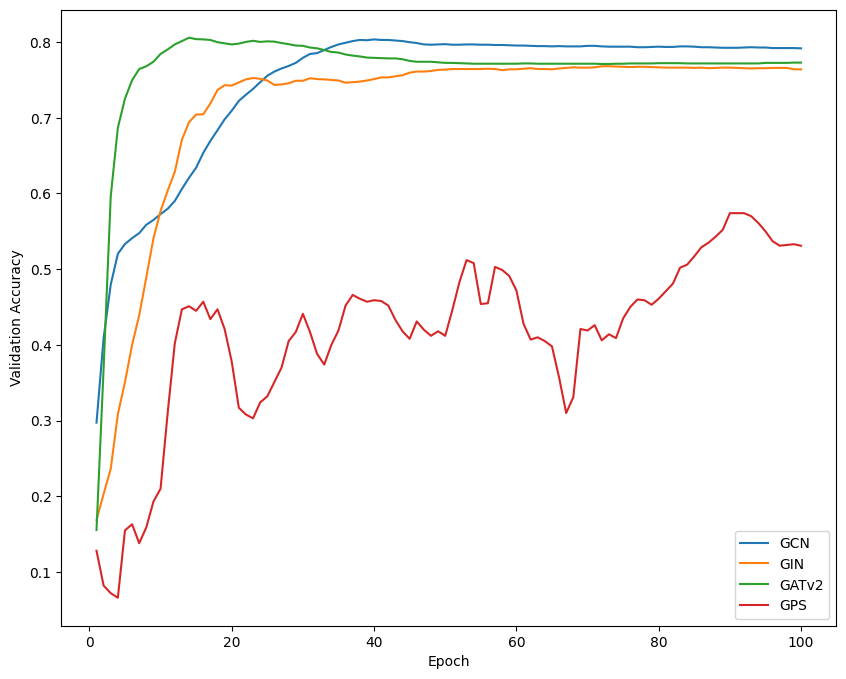

In [90]:
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__]], [x[2] for x in hist[model.__class__.__name__]], label=model.__class__.__name__)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

## IMDB

In [279]:
GCN_model = GCNG(3, 32, 2)
GIN_model = GING(3, 32, 2)
GATv2_model = GATv2G(3, 32, 2)
GPS_model = GPSG(3, 16, 3, 3, 2, 2)


models = [GCN_model, GIN_model, GATv2_model, GPS_model]

hist = {}
hist['GCN'] = []
hist['GIN'] = []
hist['GATv2'] = []
hist['GPS'] = []

In [285]:
def train_on_imdb(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in imdb_trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(imdb_trainloader.dataset)
        eval_acc = evaluate_on_imdb(model)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def evaluate_on_imdb(model):
    model.eval()
    acc = 0
    n = 0
    for data in imdb_testloader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        # print(pred)
        acc += pred.eq(data.y).sum().item()
        n += data.y.size(0)
    return acc / n
    
    
for model in models[:-1]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss = train_on_imdb(model, optimizer, 200)
    acc = evaluate_on_imdb(model)
    print(model.__class__.__name__, 'IMDB', acc)

Epoch: 000, Loss: 0.5706, Test: 0.6350
Epoch: 001, Loss: 0.5670, Test: 0.6350
Epoch: 002, Loss: 0.5779, Test: 0.6400
Epoch: 003, Loss: 0.5616, Test: 0.6350
Epoch: 004, Loss: 0.5546, Test: 0.6450
Epoch: 005, Loss: 0.5587, Test: 0.6250
Epoch: 006, Loss: 0.5720, Test: 0.6350
Epoch: 007, Loss: 0.5580, Test: 0.6250
Epoch: 008, Loss: 0.5561, Test: 0.6500
Epoch: 009, Loss: 0.5572, Test: 0.6250
Epoch: 010, Loss: 0.5563, Test: 0.6400
Epoch: 011, Loss: 0.5721, Test: 0.6300
Epoch: 012, Loss: 0.5860, Test: 0.6350
Epoch: 013, Loss: 0.5704, Test: 0.6500
Epoch: 014, Loss: 0.5559, Test: 0.6500
Epoch: 015, Loss: 0.5481, Test: 0.6500
Epoch: 016, Loss: 0.5453, Test: 0.6400
Epoch: 017, Loss: 0.5462, Test: 0.6400
Epoch: 018, Loss: 0.5507, Test: 0.6450
Epoch: 019, Loss: 0.5618, Test: 0.6600
Epoch: 020, Loss: 0.5507, Test: 0.6350
Epoch: 021, Loss: 0.5556, Test: 0.6250
Epoch: 022, Loss: 0.5618, Test: 0.6200
Epoch: 023, Loss: 0.5537, Test: 0.6400
Epoch: 024, Loss: 0.5558, Test: 0.6500
Epoch: 025, Loss: 0.5467,

In [286]:
def train_GPSG_on_imdb(epoch, model, optimizer, train_loader):
    model.train()
    for epoch in range(epoch):
        total_loss = 0
        for data in imdb_trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.pe, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(imdb_trainloader.dataset)
        eval_acc = test_GPSG(model, imdb_testloader)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def test_GPSG(model, loader):
    model.eval()
    acc = 0
    n = 0
    for data in imdb_testloader:
        data = data.to(device)
        out = model(data.x, data.pe, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        # print(pred)
        acc += pred.eq(data.y).sum().item()
        n += data.y.size(0)
    return acc / n

optimizer = torch.optim.Adam(GPS_model.parameters(), lr=0.005)
train_GPSG_on_imdb(200, GPS_model, optimizer, imdb_trainloader)

Epoch: 000, Loss: 0.6443, Test: 0.6450
Epoch: 001, Loss: 0.5538, Test: 0.6150
Epoch: 002, Loss: 0.5474, Test: 0.6300
Epoch: 003, Loss: 0.5277, Test: 0.6550
Epoch: 004, Loss: 0.5178, Test: 0.6450
Epoch: 005, Loss: 0.5154, Test: 0.6450
Epoch: 006, Loss: 0.5131, Test: 0.6600
Epoch: 007, Loss: 0.5132, Test: 0.6750
Epoch: 008, Loss: 0.5169, Test: 0.6600
Epoch: 009, Loss: 0.5113, Test: 0.6500
Epoch: 010, Loss: 0.5128, Test: 0.6550
Epoch: 011, Loss: 0.5056, Test: 0.6600
Epoch: 012, Loss: 0.4984, Test: 0.6300
Epoch: 013, Loss: 0.5039, Test: 0.6200
Epoch: 014, Loss: 0.5024, Test: 0.6450
Epoch: 015, Loss: 0.5074, Test: 0.6600
Epoch: 016, Loss: 0.4953, Test: 0.6450
Epoch: 017, Loss: 0.6108, Test: 0.5750
Epoch: 018, Loss: 0.6156, Test: 0.6450
Epoch: 019, Loss: 0.5465, Test: 0.6500
Epoch: 020, Loss: 0.5185, Test: 0.6700
Epoch: 021, Loss: 0.5082, Test: 0.6650
Epoch: 022, Loss: 0.5051, Test: 0.6700
Epoch: 023, Loss: 0.4998, Test: 0.6400
Epoch: 024, Loss: 0.5085, Test: 0.6400
Epoch: 025, Loss: 0.4976,

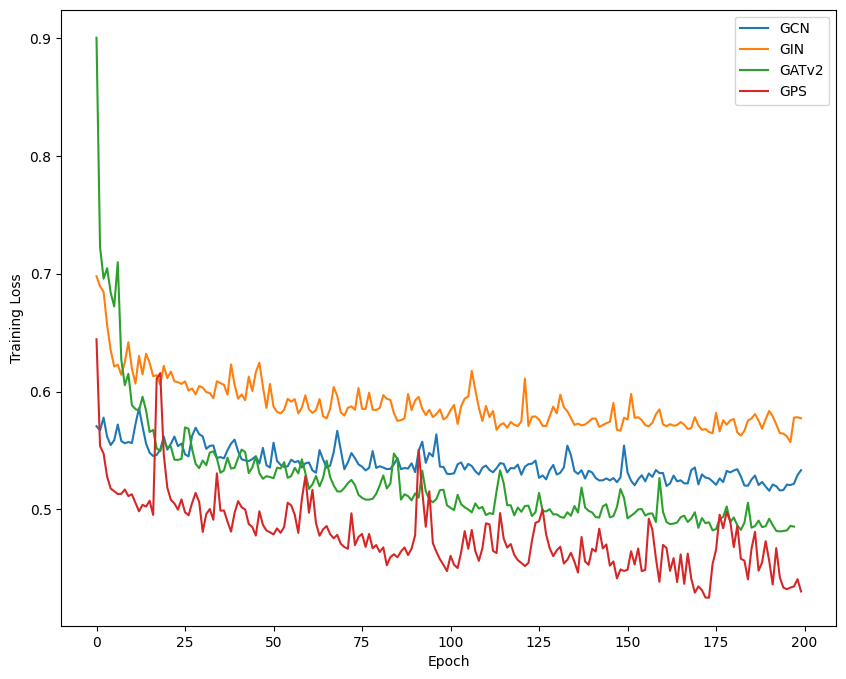

In [410]:
# plot losses
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[1] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()


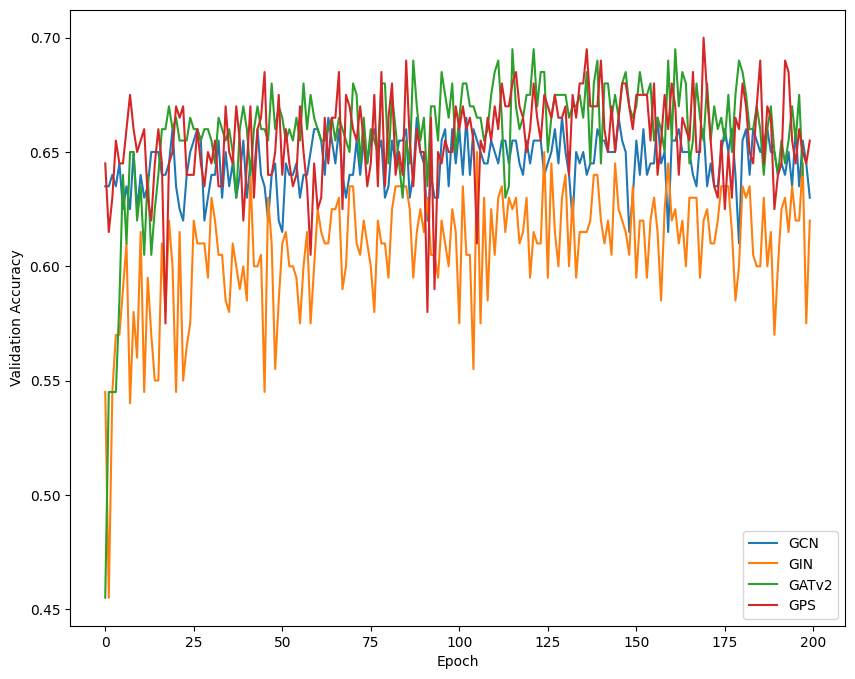

In [411]:
# plot accuracies
plt.figure(figsize=(10, 8))

for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[2] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()


## LRGB

In [391]:
GCN_model = GCNG(lrgb_ds.num_features, 32, lrgb_ds.num_classes)
GIN_model = GING(lrgb_ds.num_features, 32, lrgb_ds.num_classes)
GATv2_model = GATv2G(lrgb_ds.num_features, 32, lrgb_ds.num_classes)
GPS_model = GPSG(lrgb_ds.num_features, 16, 7, 3, 2, lrgb_ds.num_classes)

models = [GCN_model, GIN_model, GATv2_model, GPS_model]

hist = {}
hist['GCN'] = []
hist['GIN'] = []
hist['GATv2'] = []
hist['GPS'] = []

In [392]:
def train_on_lrgb(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in lrgb_trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            # print(data)
            data.x = data.x.float()
            out = model(data)

            if data.y.ndim > 1:
                t = data.y.argmax(dim=1)
            else:
                t = data.y

            loss = F.cross_entropy(out, t)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(lrgb_trainloader.dataset)
        eval_acc = evaluate_on_lrgb(model)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def evaluate_on_lrgb(model):
    model.eval()
    acc = 0
    n = 0
    for data in lrgb_testloader:
        data = data.to(device)
        data.x = data.x.float()
        out = model(data)

        if data.y.ndim > 1:
                t = data.y.argmax(dim=1)
        else:
            t = data.y


        pred = out.argmax(dim=1)
        # print(pred, data.y)
        acc += pred.eq(t).sum().item()
        n += data.y.size(0)
    return acc / n
    
    
for model in models[:-1]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss = train_on_lrgb(model, optimizer, 100)
    acc = evaluate_on_lrgb(model)
    print(model.__class__.__name__, 'LRGB', acc)

Epoch: 000, Loss: 1.5086, Test: 0.5140
Epoch: 001, Loss: 1.4434, Test: 0.5131
Epoch: 002, Loss: 1.4248, Test: 0.5274
Epoch: 003, Loss: 1.4146, Test: 0.4786
Epoch: 004, Loss: 1.4141, Test: 0.5301
Epoch: 005, Loss: 1.4052, Test: 0.5338
Epoch: 006, Loss: 1.4010, Test: 0.5255
Epoch: 007, Loss: 1.4036, Test: 0.5269
Epoch: 008, Loss: 1.3995, Test: 0.5287
Epoch: 009, Loss: 1.3991, Test: 0.5347
Epoch: 010, Loss: 1.3941, Test: 0.5347
Epoch: 011, Loss: 1.3922, Test: 0.5034
Epoch: 012, Loss: 1.3944, Test: 0.5416
Epoch: 013, Loss: 1.3891, Test: 0.5379
Epoch: 014, Loss: 1.3890, Test: 0.5444
Epoch: 015, Loss: 1.3821, Test: 0.5398
Epoch: 016, Loss: 1.3905, Test: 0.5269
Epoch: 017, Loss: 1.3886, Test: 0.5274
Epoch: 018, Loss: 1.3878, Test: 0.5343
Epoch: 019, Loss: 1.3893, Test: 0.5379
Epoch: 020, Loss: 1.3841, Test: 0.5034
Epoch: 021, Loss: 1.3809, Test: 0.5384
Epoch: 022, Loss: 1.3752, Test: 0.5439
Epoch: 023, Loss: 1.3753, Test: 0.5402
Epoch: 024, Loss: 1.3742, Test: 0.5444
Epoch: 025, Loss: 1.3807,

In [386]:
def train_GPSG_on_lrgb(epoch, model, optimizer, train_loader):
    model.train()
    for epoch in range(epoch):
        total_loss = 0
        for data in lrgb_trainloader:
            data = data.to(device)
            data.x = data.x.float()
            optimizer.zero_grad()
            out = model(data.x, data.pe, data.edge_index, data.batch)

            if data.y.ndim > 1:
                t = data.y.argmax(dim=1)
            else:
                t = data.y

            loss = F.cross_entropy(out, t)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(lrgb_trainloader.dataset)
        eval_acc = test_GPSG(model, lrgb_testloader)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def test_GPSG(model, loader):
    model.eval()
    acc = 0
    n = 0
    for data in lrgb_testloader:
        data = data.to(device)

        if data.y.ndim > 1:
                t = data.y.argmax(dim=1)
        else:
            t = data.y

        out = model(data.x, data.pe, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        # print(pred)
        acc += pred.eq(t).sum().item()
        n += data.y.size(0)
    return acc / n

optimizer = torch.optim.Adam(GPS_model.parameters(), lr=0.005)
train_GPSG_on_lrgb(100, GPS_model, optimizer, imdb_trainloader)

Epoch: 000, Loss: 1.5181, Test: 0.2446
Epoch: 001, Loss: 1.4754, Test: 0.5122
Epoch: 002, Loss: 1.2769, Test: 0.6028
Epoch: 003, Loss: 1.2190, Test: 0.5913
Epoch: 004, Loss: 1.2076, Test: 0.6175
Epoch: 005, Loss: 1.1901, Test: 0.6018
Epoch: 006, Loss: 1.1841, Test: 0.6179
Epoch: 007, Loss: 1.1811, Test: 0.6193
Epoch: 008, Loss: 1.1714, Test: 0.6143
Epoch: 009, Loss: 1.1642, Test: 0.6322
Epoch: 010, Loss: 1.1564, Test: 0.5945
Epoch: 011, Loss: 1.1519, Test: 0.6271
Epoch: 012, Loss: 1.1376, Test: 0.6326
Epoch: 013, Loss: 1.1356, Test: 0.6331
Epoch: 014, Loss: 1.1429, Test: 0.6354
Epoch: 015, Loss: 1.1283, Test: 0.6359
Epoch: 016, Loss: 1.1214, Test: 0.6161
Epoch: 017, Loss: 1.1201, Test: 0.6391
Epoch: 018, Loss: 1.1164, Test: 0.6386
Epoch: 019, Loss: 1.1215, Test: 0.6368
Epoch: 020, Loss: 1.1154, Test: 0.6271
Epoch: 021, Loss: 1.1071, Test: 0.6230
Epoch: 022, Loss: 1.1018, Test: 0.6285
Epoch: 023, Loss: 1.1110, Test: 0.6211
Epoch: 024, Loss: 1.1077, Test: 0.6469
Epoch: 025, Loss: 1.1031,

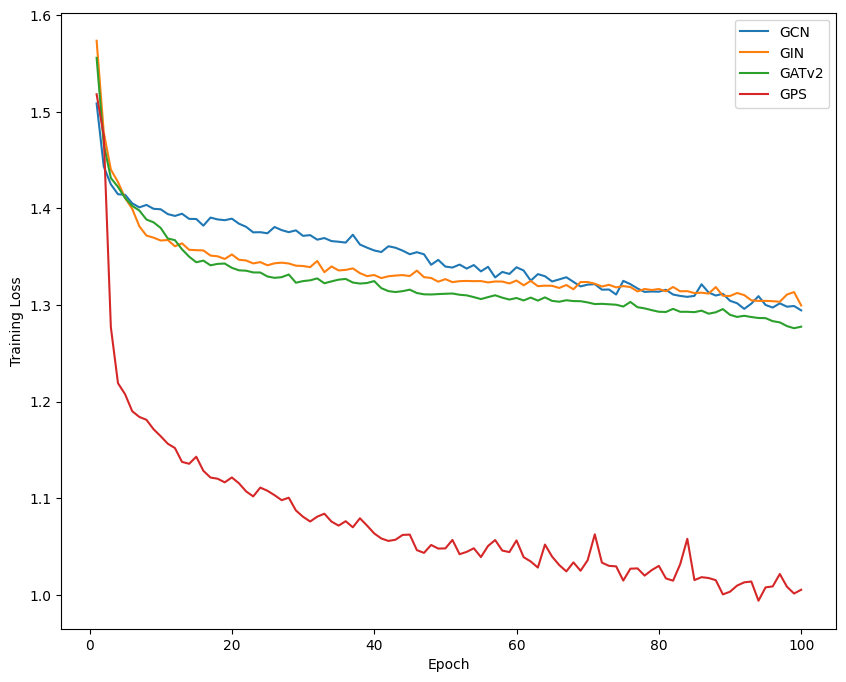

In [395]:
# plot losses
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[1] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()


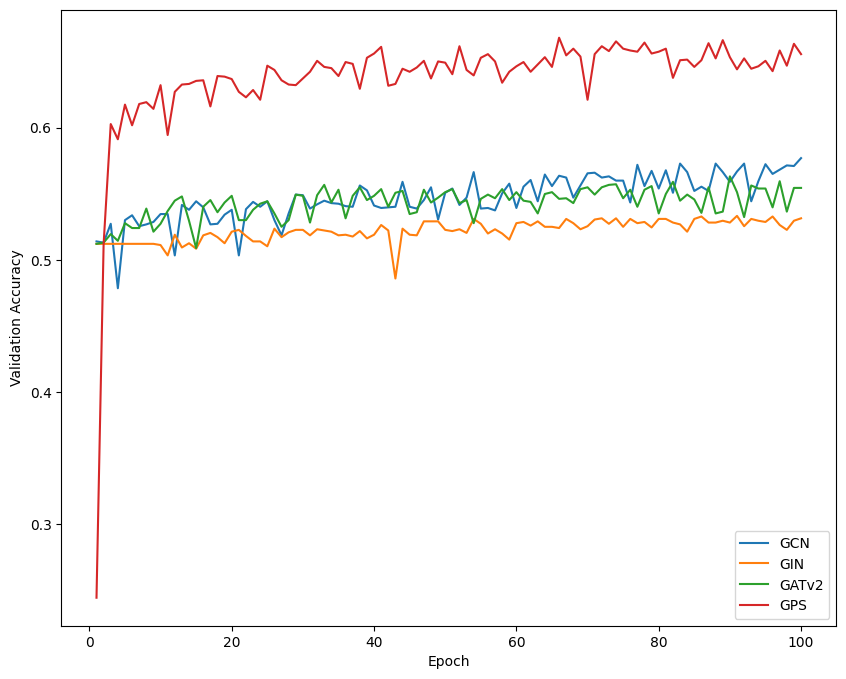

In [396]:
# plot accuracies
plt.figure(figsize=(10, 8))

for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[2] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()


## Enzyme

In [311]:
GCN_model = GCNG(enzyme_ds.num_features, 32, enzyme_ds.num_classes)
GIN_model = GING(enzyme_ds.num_features, 32, enzyme_ds.num_classes)
GATv2_model = GATv2G(enzyme_ds.num_features, 32, enzyme_ds.num_classes)
GPS_model = GPSG(enzyme_ds.num_features, 32, 7, 8, 3, enzyme_ds.num_classes)

models = [GCN_model, GIN_model, GATv2_model, GPS_model]

hist = {}
hist['GCN'] = []
hist['GIN'] = []
hist['GATv2'] = []
hist['GPS'] = []

In [312]:

def train_on_enzyme(model, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in enzyme_trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(enzyme_trainloader.dataset)
        eval_acc = evaluate_on_enzyme(model)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def evaluate_on_enzyme(model):
    model.eval()
    acc = 0
    n = 0
    for data in enzyme_testloader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        # print(pred)
        acc += pred.eq(data.y).sum().item()
        n += data.y.size(0)
    return acc / n

for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss = train_on_enzyme(model, optimizer, 400)
    acc = evaluate_on_enzyme(model)
    print(model.__class__.__name__, 'ENZYME', acc)

Epoch: 000, Loss: 1.7980, Test: 0.1667
Epoch: 001, Loss: 1.7801, Test: 0.2500
Epoch: 002, Loss: 1.7719, Test: 0.1750
Epoch: 003, Loss: 1.7620, Test: 0.2333
Epoch: 004, Loss: 1.7553, Test: 0.2417
Epoch: 005, Loss: 1.7474, Test: 0.2583
Epoch: 006, Loss: 1.7374, Test: 0.2333
Epoch: 007, Loss: 1.7371, Test: 0.2583
Epoch: 008, Loss: 1.7298, Test: 0.2250
Epoch: 009, Loss: 1.7306, Test: 0.2750
Epoch: 010, Loss: 1.7304, Test: 0.2583
Epoch: 011, Loss: 1.7223, Test: 0.2583
Epoch: 012, Loss: 1.7188, Test: 0.2500
Epoch: 013, Loss: 1.7205, Test: 0.2333
Epoch: 014, Loss: 1.7157, Test: 0.2417
Epoch: 015, Loss: 1.7144, Test: 0.2833
Epoch: 016, Loss: 1.7060, Test: 0.2583
Epoch: 017, Loss: 1.7147, Test: 0.2333
Epoch: 018, Loss: 1.7089, Test: 0.2833
Epoch: 019, Loss: 1.7150, Test: 0.2917
Epoch: 020, Loss: 1.7000, Test: 0.2917
Epoch: 021, Loss: 1.6969, Test: 0.3250
Epoch: 022, Loss: 1.7002, Test: 0.2833
Epoch: 023, Loss: 1.7009, Test: 0.2833
Epoch: 024, Loss: 1.6927, Test: 0.2750
Epoch: 025, Loss: 1.6883,

In [327]:
hist['GPS'] = []
GPS_model = GPSG(enzyme_ds.num_features, 32, 7, 8, 1, enzyme_ds.num_classes)

def train_GPSG_on_enzyme(epoch, model, optimizer, train_loader):
    model.train()
    for epoch in range(epoch):
        total_loss = 0
        for data in enzyme_trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.pe, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            loss.backward()
            total_loss += loss.item() * data.num_graphs
            optimizer.step()
        total_loss /= len(enzyme_trainloader.dataset)
        eval_acc = test_GPSG(model, enzyme_testloader)
        # if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {total_loss:.4f}, Test: {eval_acc:.4f}')
        hist[model.__class__.__name__[:-1]].append((epoch + 1, total_loss, eval_acc))
    return 

def test_GPSG(model, loader):
    model.eval()
    acc = 0
    n = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pe, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        # print(pred)
        acc += pred.eq(data.y).sum().item()
        n += data.y.size(0)
    return acc / n

optimizer = torch.optim.Adam(GPS_model.parameters(), lr=0.01)
train_GPSG_on_enzyme(400, GPS_model, optimizer, imdb_trainloader)

Epoch: 000, Loss: 1.8180, Test: 0.1333
Epoch: 001, Loss: 1.7984, Test: 0.1250
Epoch: 002, Loss: 1.7924, Test: 0.1583
Epoch: 003, Loss: 1.7878, Test: 0.2000
Epoch: 004, Loss: 1.7800, Test: 0.2000
Epoch: 005, Loss: 1.7780, Test: 0.2333
Epoch: 006, Loss: 1.7786, Test: 0.1583
Epoch: 007, Loss: 1.7581, Test: 0.2250
Epoch: 008, Loss: 1.7587, Test: 0.2083
Epoch: 009, Loss: 1.7360, Test: 0.2417
Epoch: 010, Loss: 1.7363, Test: 0.2750
Epoch: 011, Loss: 1.7208, Test: 0.2750
Epoch: 012, Loss: 1.7223, Test: 0.1750
Epoch: 013, Loss: 1.7413, Test: 0.2167
Epoch: 014, Loss: 1.7160, Test: 0.2833
Epoch: 015, Loss: 1.7156, Test: 0.3000
Epoch: 016, Loss: 1.7161, Test: 0.2333
Epoch: 017, Loss: 1.7144, Test: 0.2583
Epoch: 018, Loss: 1.6985, Test: 0.2500
Epoch: 019, Loss: 1.6886, Test: 0.1833
Epoch: 020, Loss: 1.7110, Test: 0.2750
Epoch: 021, Loss: 1.6794, Test: 0.2333
Epoch: 022, Loss: 1.6750, Test: 0.2750
Epoch: 023, Loss: 1.6524, Test: 0.2667
Epoch: 024, Loss: 1.6651, Test: 0.2750
Epoch: 025, Loss: 1.6383,

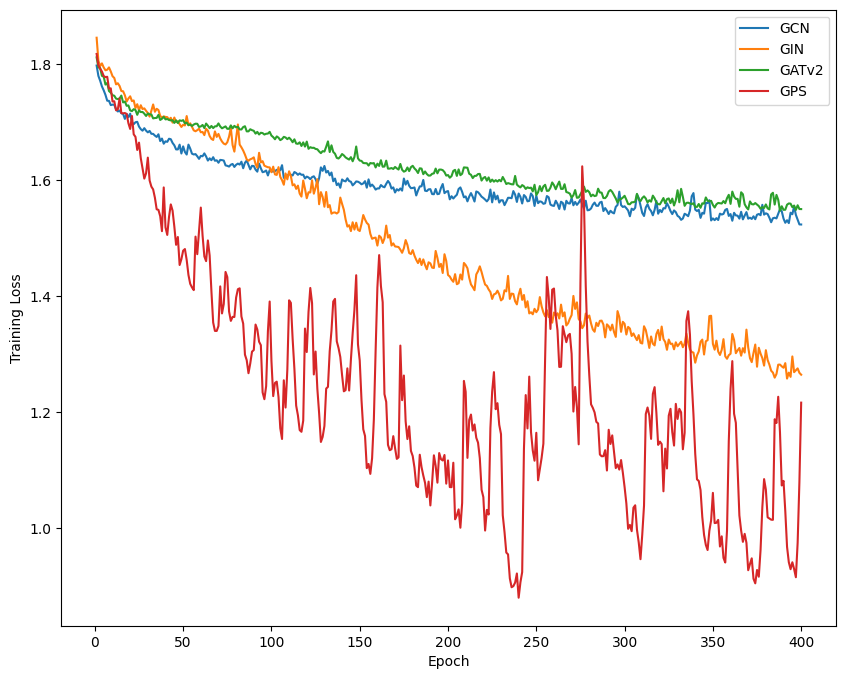

In [328]:
# plot losses
plt.figure(figsize=(10, 8))
for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[1] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()


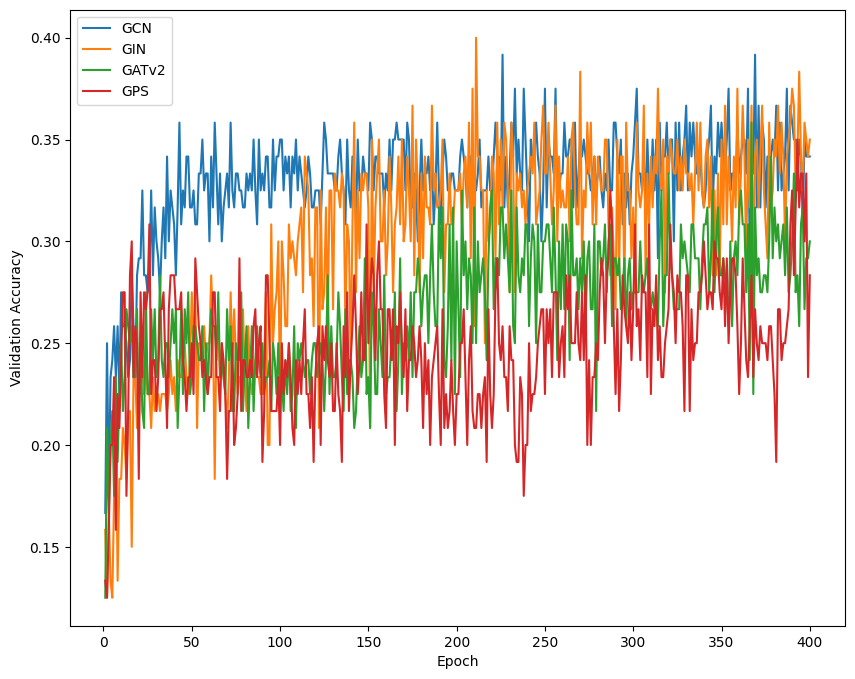

In [329]:
# plot accuracies
plt.figure(figsize=(10, 8))

for model in models:
    plt.plot([x[0] for x in hist[model.__class__.__name__[:-1]]], [x[2] for x in hist[model.__class__.__name__[:-1]]], label=model.__class__.__name__[:-1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
